In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, constraints, initializers
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from skimage import io, img_as_ubyte
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [248]:
data = []

In [249]:
def calculate_glcm_properties_per_rgb_channel(image_list, label):
    contrast_r, contrast_g, contrast_b = [], [], []
    correlation_r, correlation_g, correlation_b = [], [], []
    homogeneity_r, homogeneity_g, homogeneity_b = [], [], []
    dissimilarity_r, dissimilarity_g, dissimilarity_b = [], [], []
    energy_r, energy_g, energy_b = [], [], []
    
    for img_path in image_list:
        image = io.imread(img_path)
        
        # Pisahkan channel warna
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]
        
        # Menghitung GLCM untuk setiap channel
        def glcm_props(channel):
            image = img_as_ubyte(channel)

            bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
            inds = np.digitize(image, bins)

            max_value = inds.max()+1
            glcm = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, symmetric=False, normed=False)

            contrast = graycoprops(glcm, 'contrast')
            correlation = graycoprops(glcm, 'correlation')
            homogeneity = graycoprops(glcm, 'homogeneity')
            dissimilarity = graycoprops(glcm, 'dissimilarity')
            energy = graycoprops(glcm, 'energy')

            return contrast, correlation, homogeneity, dissimilarity, energy

        # Ekstraksi properti untuk tiap channel
        c_r, co_r, h_r, d_r, e_r = glcm_props(red_channel)
        c_g, co_g, h_g, d_g, e_g = glcm_props(green_channel)
        c_b, co_b, h_b, d_b, e_b = glcm_props(blue_channel)

        row = {
            'filepath': img_path,
            'label': label,
            'type': 'rgb',
            'rgb_contrast_r': np.mean(c_r),
            'rgb_correlation_r': np.mean(co_r),
            'rgb_homogeneity_r': np.mean(h_r),
            'rgb_dissimilarity_r': np.mean(d_r),
            'rgb_energy_r': np.mean(e_r),
            'rgb_contrast_g': np.mean(c_g),
            'rgb_correlation_g': np.mean(co_g),
            'rgb_homogeneity_g': np.mean(h_g),
            'rgb_dissimilarity_g': np.mean(d_g),
            'rgb_energy_g': np.mean(e_g),
            'rgb_contrast_b': np.mean(c_b),
            'rgb_correlation_b': np.mean(co_b),
            'rgb_homogeneity_b': np.mean(h_b),
            'rgb_dissimilarity_b': np.mean(d_b),
            'rgb_energy_b': np.mean(e_b)
        }

        data.append(row)
        
        contrast_r.append(c_r)
        correlation_r.append(co_r)
        homogeneity_r.append(h_r)
        dissimilarity_r.append(d_r)
        energy_r.append(e_r)
        
        contrast_g.append(c_g)
        correlation_g.append(co_g)
        homogeneity_g.append(h_g)
        dissimilarity_g.append(d_g)
        energy_g.append(e_g)
        
        contrast_b.append(c_b)
        correlation_b.append(co_b)
        homogeneity_b.append(h_b)
        dissimilarity_b.append(d_b)
        energy_b.append(e_b)
    
    # Mengembalikan rata-rata dari setiap properti
    return (np.mean(contrast_r), np.mean(correlation_r), np.mean(homogeneity_r), np.mean(dissimilarity_r), np.mean(energy_r),
            np.mean(contrast_g), np.mean(correlation_g), np.mean(homogeneity_g), np.mean(dissimilarity_g), np.mean(energy_g),
            np.mean(contrast_b), np.mean(correlation_b), np.mean(homogeneity_b), np.mean(dissimilarity_b), np.mean(energy_b),
            np.std(contrast_r), np.std(correlation_r), np.std(homogeneity_r), np.std(dissimilarity_r), np.std(energy_r),
            np.std(contrast_g), np.std(correlation_g), np.std(homogeneity_g), np.std(dissimilarity_g), np.std(energy_g),
            np.std(contrast_b), np.std(correlation_b), np.std(homogeneity_b), np.std(dissimilarity_b), np.std(energy_b))

In [250]:
base_dir = 'data/'

sessions = [
    [os.path.join(base_dir, 'branded', 'rgb', f'branded_{i}.jpg') for i in range(1, 61)],
    [os.path.join(base_dir, 'unbranded', 'rgb', f'unbranded_{i}.jpg') for i in range(1, 61)],
]

In [251]:
avg_contrast_r, avg_correlation_r, avg_homogeneity_r, avg_dissimilarity_r, avg_energy_r = [], [], [], [], []
avg_contrast_g, avg_correlation_g, avg_homogeneity_g, avg_dissimilarity_g, avg_energy_g = [], [], [], [], []
avg_contrast_b, avg_correlation_b, avg_homogeneity_b, avg_dissimilarity_b, avg_energy_b = [], [], [], [], []

std_contrast_r, std_correlation_r, std_homogeneity_r, std_dissimilarity_r, std_energy_r = [], [], [], [], []
std_contrast_g, std_correlation_g, std_homogeneity_g, std_dissimilarity_g, std_energy_g = [], [], [], [], []
std_contrast_b, std_correlation_b, std_homogeneity_b, std_dissimilarity_b, std_energy_b = [], [], [], [], []

for session in sessions:
    label = 'Saus ABC' if sessions.index(session) == 0 else 'Saus Tradisional'

    c_r, co_r, h_r, d_r, e_r, c_g, co_g, h_g, d_g, e_g, c_b, co_b, h_b, d_b, e_b, std_c_r, std_co_r, std_h_r, std_d_r, std_e_r, std_c_g, std_co_g, std_h_g, std_d_g, std_e_g, std_c_b, std_co_b, std_h_b, std_d_b, std_e_b = calculate_glcm_properties_per_rgb_channel(session, label=label)
    
    avg_contrast_r.append(c_r)
    avg_correlation_r.append(co_r)
    avg_homogeneity_r.append(h_r)
    avg_dissimilarity_r.append(d_r)
    avg_energy_r.append(e_r)
    
    avg_contrast_g.append(c_g)
    avg_correlation_g.append(co_g)
    avg_homogeneity_g.append(h_g)
    avg_dissimilarity_g.append(d_g)
    avg_energy_g.append(e_g)
    
    avg_contrast_b.append(c_b)
    avg_correlation_b.append(co_b)
    avg_homogeneity_b.append(h_b)
    avg_dissimilarity_b.append(d_b)
    avg_energy_b.append(e_b)

    std_contrast_r.append(std_c_r)
    std_correlation_r.append(std_co_r)
    std_homogeneity_r.append(std_h_r)
    std_dissimilarity_r.append(std_d_r)
    std_energy_r.append(std_e_r)
    
    std_contrast_g.append(std_c_g)
    std_correlation_g.append(std_co_g)
    std_homogeneity_g.append(std_h_g)
    std_dissimilarity_g.append(std_d_g)
    std_energy_g.append(std_e_g)
    
    std_contrast_b.append(std_c_b)
    std_correlation_b.append(std_co_b)
    std_homogeneity_b.append(std_h_b)
    std_dissimilarity_b.append(std_d_b)
    std_energy_b.append(std_e_b)

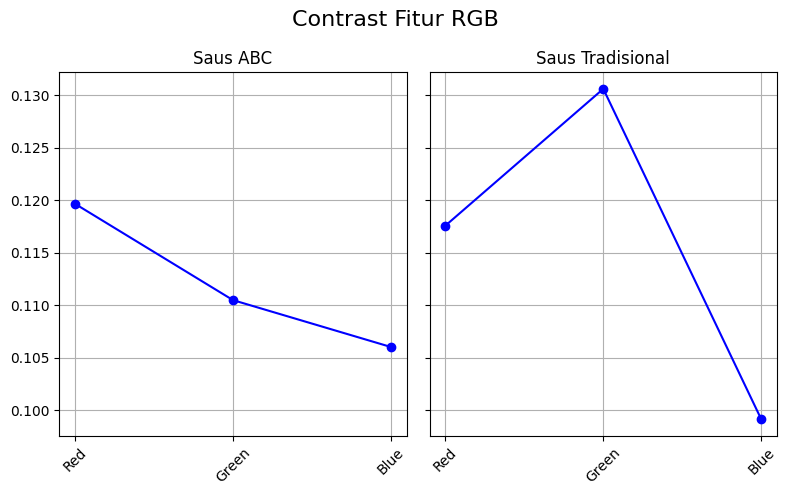

In [252]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_contrast_r[i], avg_contrast_g[i], avg_contrast_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Contrast Fitur RGB', fontsize=16)
plt.tight_layout()
plt.show()

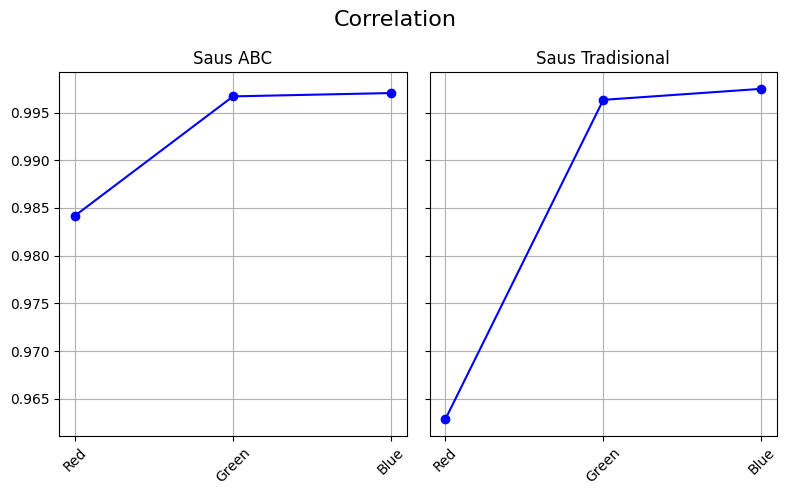

In [253]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_correlation_r[i], avg_correlation_g[i], avg_correlation_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Correlation', fontsize=16)
plt.tight_layout()
plt.show()

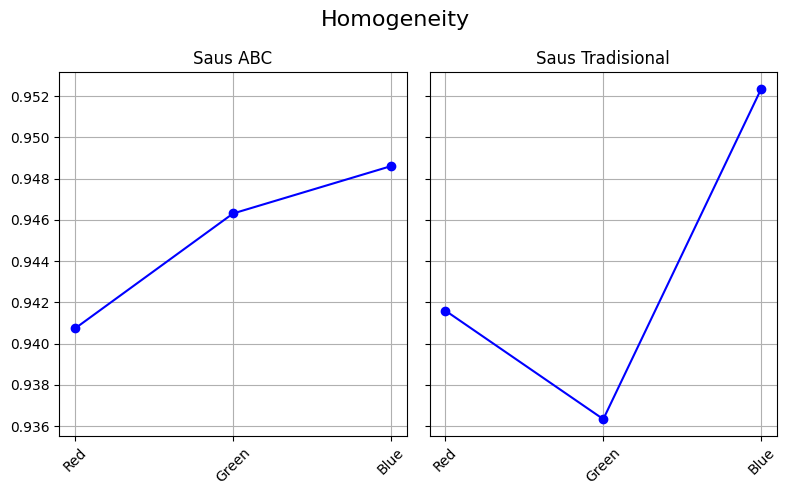

In [254]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_homogeneity_r[i], avg_homogeneity_g[i], avg_homogeneity_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Homogeneity', fontsize=16)
plt.tight_layout()
plt.show()

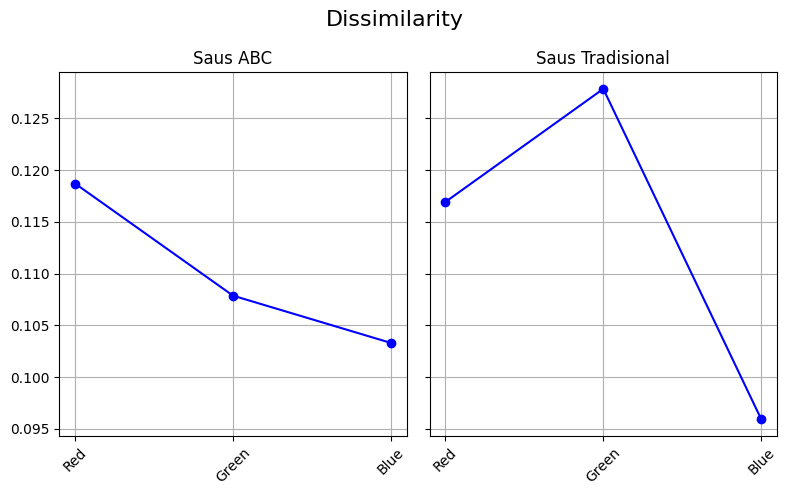

In [255]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_dissimilarity_r[i], avg_dissimilarity_g[i], avg_dissimilarity_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Dissimilarity', fontsize=16)
plt.tight_layout()
plt.show()

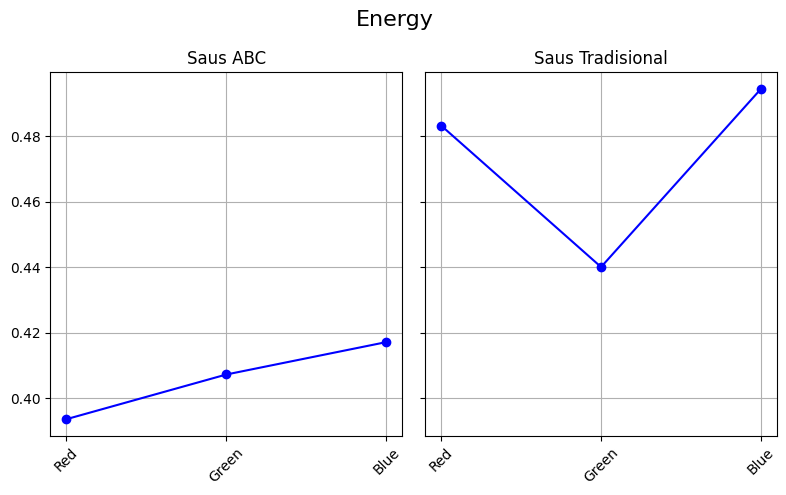

In [256]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_energy_r[i], avg_energy_g[i], avg_energy_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Energy', fontsize=16)
plt.tight_layout()
plt.show()

In [257]:
# ABC
print("\t\t\tStandar Deviasi\n")
print("\t\tRed\t\t\tGreen\t\t\tBlue")
print("Contrast \t{:}\t{:}\t{:}".format(std_contrast_r[0], std_contrast_g[0], std_contrast_b[0]))
print("Correlation \t{:}\t{:}\t{:}".format(std_correlation_r[0], std_correlation_g[0], std_correlation_b[0]))
print("Homogeneity \t{:}\t{:}\t{:}".format(std_homogeneity_r[0], std_homogeneity_g[0], std_homogeneity_b[0]))
print("Dissimilarity \t{:}\t{:}\t{:}".format(std_dissimilarity_r[0], std_dissimilarity_g[0], std_dissimilarity_b[0]))
print("Energy \t\t{:}\t{:}\t{:}".format(std_energy_r[0], std_energy_g[0], std_energy_b[0]))

			Standar Deviasi

		Red			Green			Blue
Contrast 	0.018156413307164325	0.018181126227014423	0.017294280129697262
Correlation 	0.002414358344800084	0.0006378815255750525	0.0005899585218353258
Homogeneity 	0.008902254585201193	0.00855814077333413	0.008149974957334211
Dissimilarity 	0.01786001921007342	0.01727390691144298	0.01644667972107228
Energy 		0.008944244824942963	0.009045424132242245	0.009998528792814425


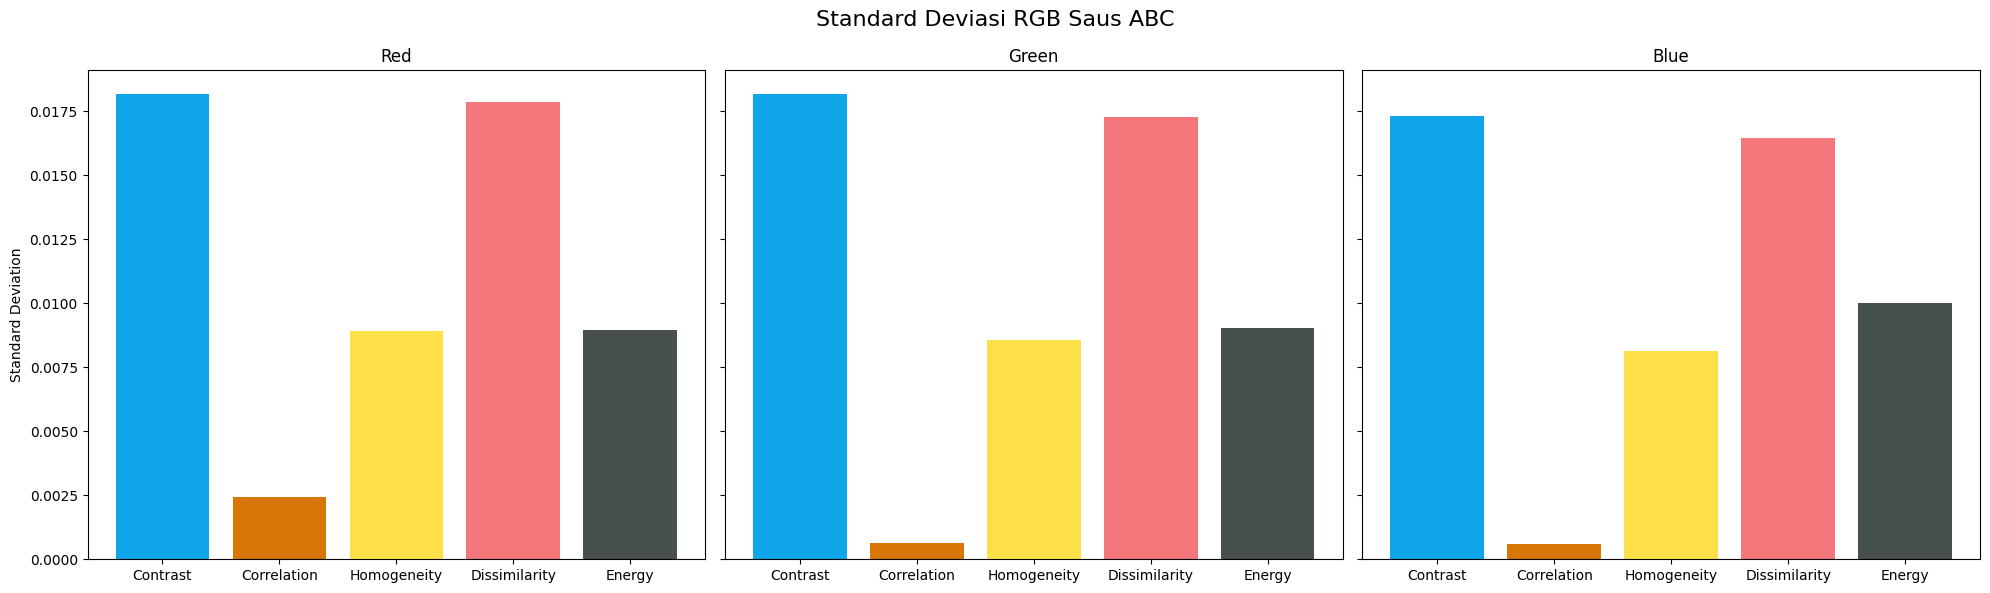

In [258]:
red_values = [std_contrast_r[0], std_correlation_r[0], std_homogeneity_r[0], std_dissimilarity_r[0], std_energy_r[0]]
green_values = [std_contrast_g[0], std_correlation_g[0], std_homogeneity_g[0], std_dissimilarity_g[0], std_energy_g[0]]
blue_values = [std_contrast_b[0], std_correlation_b[0], std_homogeneity_b[0], std_dissimilarity_b[0], std_energy_b[0]]

labels = ['Contrast', 'Correlation', 'Homogeneity', 'Dissimilarity', 'Energy']
colors = ['#0ea5e9', '#d97706', '#fde047', '#f3777b', '#484f4f']

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot untuk channel Red
axes[0].bar(labels, red_values, color=colors)
axes[0].set_title('Red')
axes[0].set_ylabel('Standard Deviation')

# Plot untuk channel Green
axes[1].bar(labels, green_values, color=colors)
axes[1].set_title('Green')

# Plot untuk channel Blue
axes[2].bar(labels, blue_values, color=colors)
axes[2].set_title('Blue')

plt.suptitle('Standard Deviasi RGB Saus ABC', fontsize=16)
plt.tight_layout()
plt.show()

In [259]:
# Tradisional
print("\t\t\tStandar Deviasi\n")
print("\t\tRed\t\tGreen\t\tBlue")
print("Contrast \t{:}\t{:}\t{:}".format(std_contrast_r[1], std_contrast_g[1], std_contrast_b[1]))
print("Correlation \t{:}\t{:}\t{:}".format(std_correlation_r[1], std_correlation_g[1], std_correlation_b[1]))
print("Homogeneity \t{:}\t{:}\t{:}".format(std_homogeneity_r[1], std_homogeneity_g[1], std_homogeneity_b[1]))
print("Dissimilarity \t{:}\t{:}\t{:}".format(std_dissimilarity_r[1], std_dissimilarity_g[1], std_dissimilarity_b[1]))
print("Energy \t\t{:}\t{:}\t{:}".format(std_energy_r[1], std_energy_g[1], std_energy_b[1]))

			Standar Deviasi

		Red		Green		Blue
Contrast 	0.01680439041674662	0.020577680595857732	0.01551244433859598
Correlation 	0.005439810084700587	0.0005800274643288282	0.00041195028862971904
Homogeneity 	0.008211230305864072	0.009576842431740446	0.00692090186864162
Dissimilarity 	0.016485805153777254	0.019383826000799374	0.014109951185609822
Energy 		0.01145957920861755	0.012705462867297694	0.00995455618440298


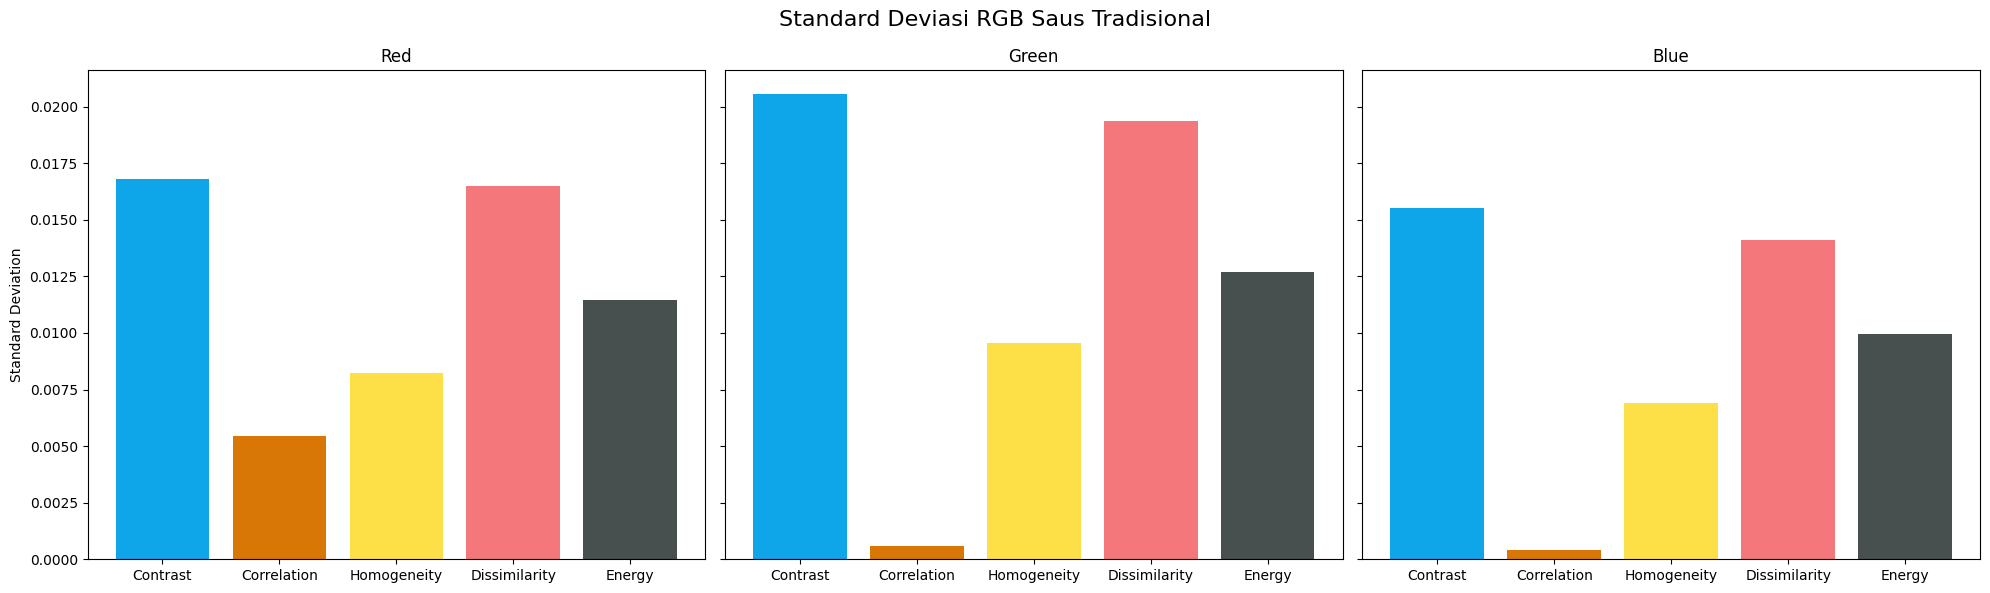

In [260]:
red_values = [std_contrast_r[1], std_correlation_r[1], std_homogeneity_r[1], std_dissimilarity_r[1], std_energy_r[1]]
green_values = [std_contrast_g[1], std_correlation_g[1], std_homogeneity_g[1], std_dissimilarity_g[1], std_energy_g[1]]
blue_values = [std_contrast_b[1], std_correlation_b[1], std_homogeneity_b[1], std_dissimilarity_b[1], std_energy_b[1]]

labels = ['Contrast', 'Correlation', 'Homogeneity', 'Dissimilarity', 'Energy']
colors = ['#0ea5e9', '#d97706', '#fde047', '#f3777b', '#484f4f']

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot untuk channel Red
axes[0].bar(labels, red_values, color=colors)
axes[0].set_title('Red')
axes[0].set_ylabel('Standard Deviation')

# Plot untuk channel Green
axes[1].bar(labels, green_values, color=colors)
axes[1].set_title('Green')

# Plot untuk channel Blue
axes[2].bar(labels, blue_values, color=colors)
axes[2].set_title('Blue')

plt.suptitle('Standard Deviasi RGB Saus Tradisional', fontsize=16)
plt.tight_layout()
plt.show()

In [261]:
def calculate_glcm_properties_nir_channel(image_list):
    contrast_list, correlation_list, homogeneity_list, dissimilarity_list, energy_list = [], [], [], [], []
    
    for img_path in image_list:
        image = io.imread(img_path, as_gray=True)
        
        image = img_as_ubyte(image)

        bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
        inds = np.digitize(image, bins)

        max_value = inds.max()+1
        glcm = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, symmetric=False, normed=False)

        contrast = graycoprops(glcm, 'contrast')
        correlation = graycoprops(glcm, 'correlation')
        homogeneity = graycoprops(glcm, 'homogeneity')
        dissimilarity = graycoprops(glcm, 'dissimilarity')
        energy = graycoprops(glcm, 'energy')

        contrast_list.append(contrast)
        correlation_list.append(correlation)
        homogeneity_list.append(homogeneity)
        dissimilarity_list.append(dissimilarity)
        energy_list.append(energy)
    
    # Mengembalikan rata-rata dari setiap properti
    return (
        np.mean(contrast_list), np.mean(correlation_list), np.mean(homogeneity_list), np.mean(dissimilarity_list), np.mean(energy_list),
        np.std(contrast_list), np.std(correlation_list), np.std(homogeneity_list), np.std(dissimilarity_list), np.std(energy_list)
        )

In [262]:
base_dir = 'data/'

sessions = [
    [os.path.join(base_dir, 'branded', 'nir', f'branded_{i}.jpg') for i in range(1, 61)],
    [os.path.join(base_dir, 'unbranded', 'nir', f'unbranded_{i}.jpg') for i in range(1, 61)],
]

In [263]:
avg_contrast, avg_correlation, avg_homogeneity, avg_dissimilarity, avg_energy = [], [], [], [], []
std_contrast, std_correlation, std_homogeneity, std_dissimilarity, std_energy = [], [], [], [], []

for session in sessions:
    c, co, h, d, e, sc, sco, sh, sd, se = calculate_glcm_properties_nir_channel(session)
    
    avg_contrast.append(c)
    avg_correlation.append(co)
    avg_homogeneity.append(h)
    avg_dissimilarity.append(d)
    avg_energy.append(e)
    
    std_contrast.append(sc)
    std_correlation.append(sco)
    std_homogeneity.append(sh)
    std_dissimilarity.append(sd)
    std_energy.append(se)

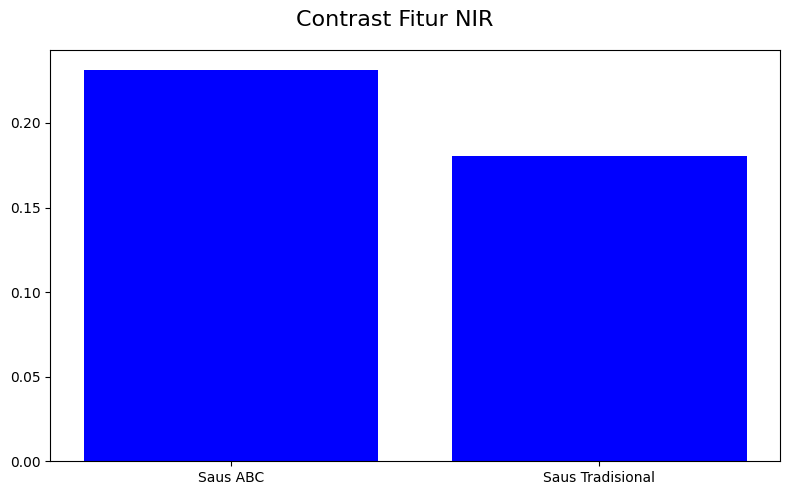

In [264]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_contrast[0], avg_contrast[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Contrast Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

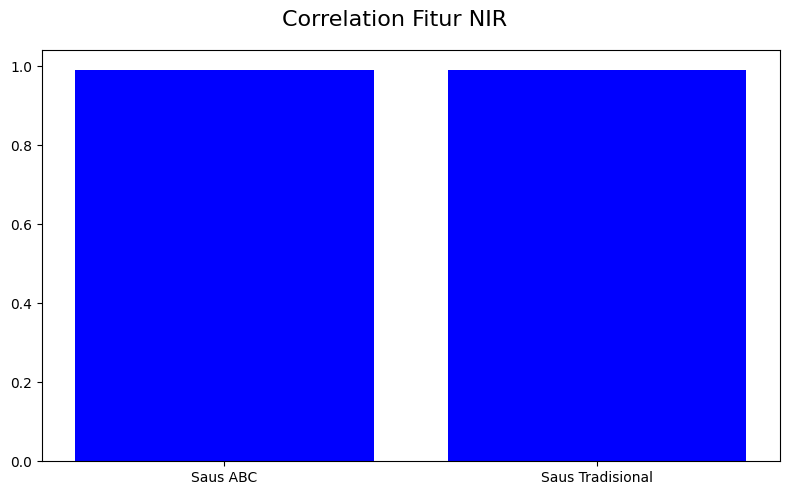

In [265]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_correlation[0], avg_correlation[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Correlation Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

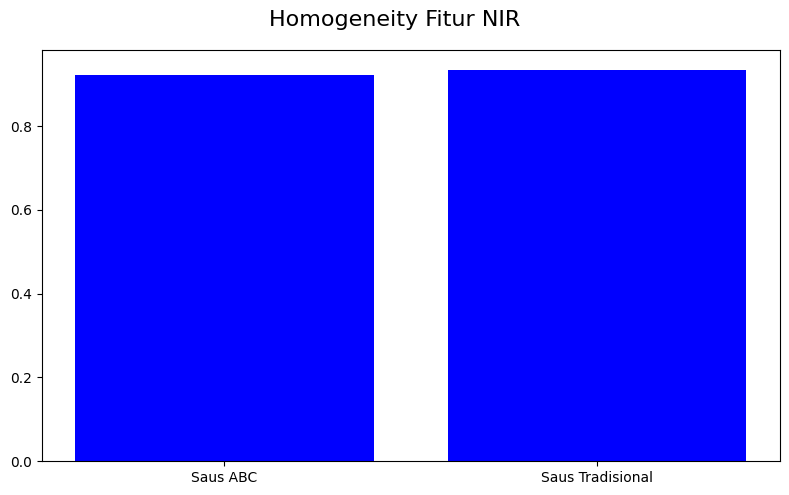

In [266]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_homogeneity[0], avg_homogeneity[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Homogeneity Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

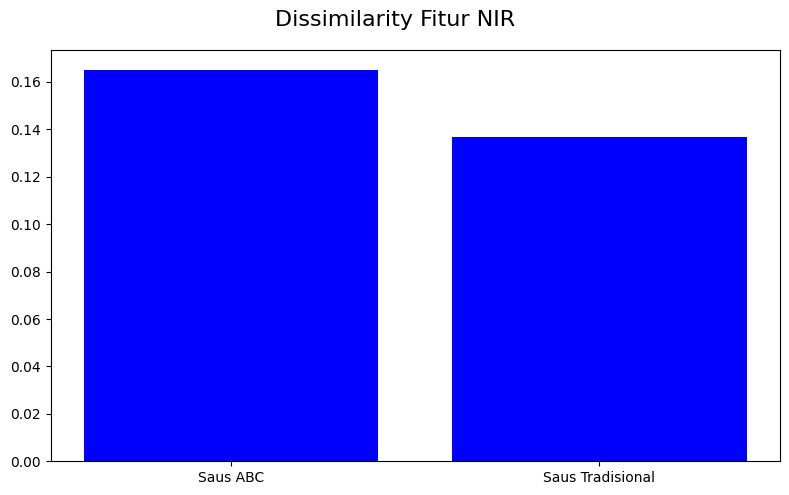

In [267]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_dissimilarity[0], avg_dissimilarity[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Dissimilarity Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

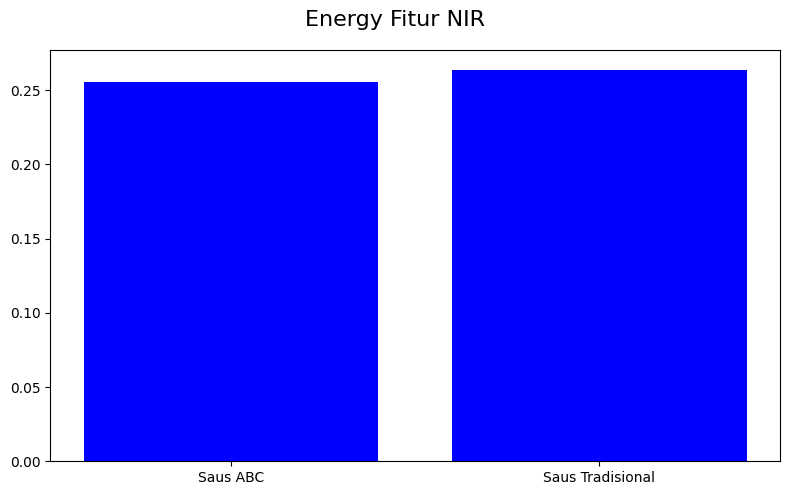

In [268]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_energy[0], avg_energy[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Energy Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

In [269]:
print("\t\t\tStandar Deviasi\n")
print("\t\t\tSaus ABC\t\t\tSaus Tradisional")
print("Contrast \t\t{:}\t\t{:}".format(std_contrast[0], std_contrast[1]))
print("Correlation \t\t{:}\t\t{:}".format(std_correlation[0], std_correlation[1]))
print("Homogeneity \t\t{:}\t\t{:}".format(std_homogeneity[0], std_homogeneity[1]))
print("Dissimilarity \t\t{:}\t\t{:}".format(std_dissimilarity[0], std_dissimilarity[1]))
print("Energy \t\t\t{:}\t\t{:}".format(std_energy[0], std_energy[1]))

			Standar Deviasi

			Saus ABC			Saus Tradisional
Contrast 		0.03485402385760868		0.022015811486825135
Correlation 		0.0014310299610524543		0.000969892005649946
Homogeneity 		0.0022240229477606603		0.0019307673677925134
Dissimilarity 		0.00832524668234536		0.004988596648452427
Energy 			0.002102962072847658		0.0013708618201326113


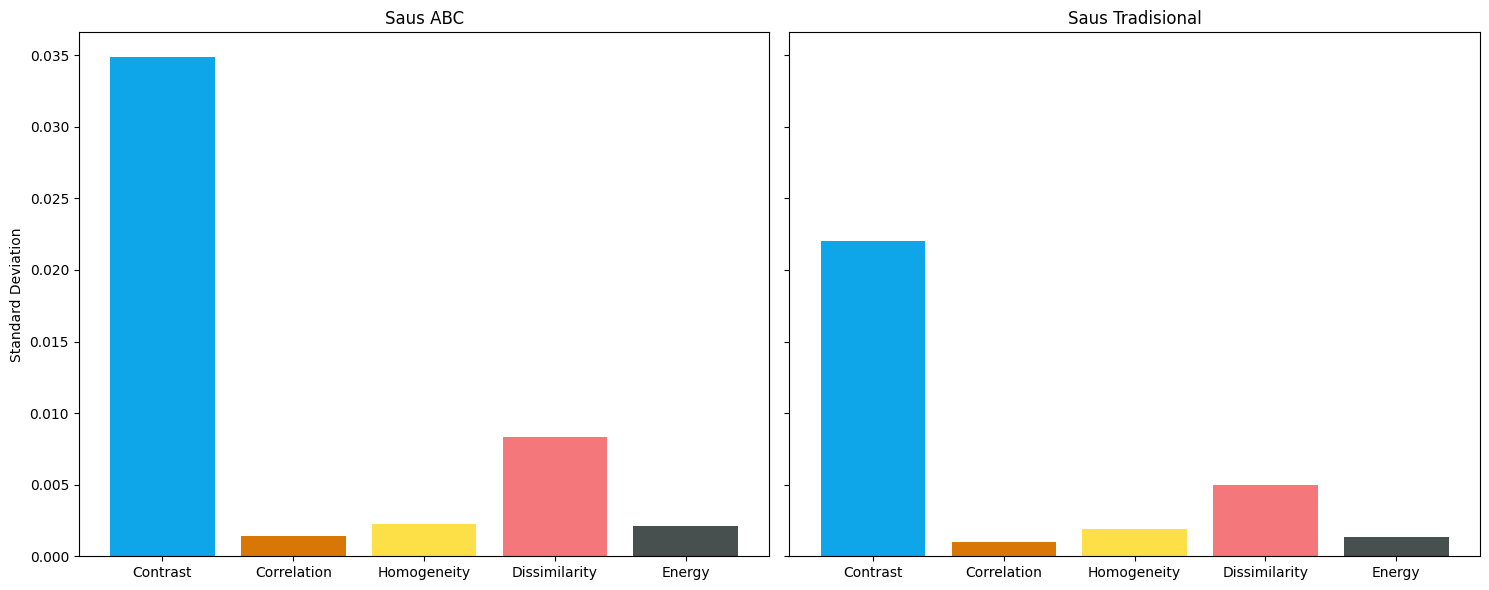

In [270]:
branded_values = [std_contrast[0], std_correlation[0], std_homogeneity[0], std_dissimilarity[0], std_energy[0]]
unbranded_values = [std_contrast[1], std_correlation[1], std_homogeneity[1], std_dissimilarity[1], std_energy[1]]

labels = ['Contrast', 'Correlation', 'Homogeneity', 'Dissimilarity', 'Energy']
colors = ['#0ea5e9', '#d97706', '#fde047', '#f3777b', '#484f4f']

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axes[0].bar(labels, branded_values, color=colors)
axes[0].set_title('Saus ABC')
axes[0].set_ylabel('Standard Deviation')

axes[1].bar(labels, unbranded_values, color=colors)
axes[1].set_title('Saus Tradisional')

plt.tight_layout()

plt.show()

In [271]:
df = pd.DataFrame(data)
df.head()

,filepath,label,type,rgb_contrast_r,rgb_correlation_r,rgb_homogeneity_r,rgb_dissimilarity_r,rgb_energy_r,rgb_contrast_g,rgb_correlation_g,rgb_homogeneity_g,rgb_dissimilarity_g,rgb_energy_g,rgb_contrast_b,rgb_correlation_b,rgb_homogeneity_b,rgb_dissimilarity_b,rgb_energy_b
0,data/branded\rgb\branded_1.jpg,Saus ABC,rgb,0.110822,0.985042,0.945325,0.109589,0.396309,0.115464,0.997056,0.944340,0.111962,0.394987,0.099697,0.997646,0.952334,0.096012,0.421837
1,data/branded\rgb\branded_2.jpg,Saus ABC,rgb,0.109893,0.985392,0.945673,0.108856,0.393139,0.108831,0.996737,0.947281,0.105972,0.401352,0.100381,0.997187,0.951563,0.097428,0.419707
2,data/branded\rgb\branded_3.jpg,Saus ABC,rgb,0.129067,0.983139,0.936355,0.127576,0.385117,0.119354,0.996740,0.942589,0.115514,0.404072,0.113452,0.997131,0.945609,0.109498,0.413727
3,data/branded\rgb\branded_4.jpg,Saus ABC,rgb,0.119690,0.983532,0.941013,0.118250,0.389072,0.123737,0.996820,0.940473,0.119769,0.389854,0.106731,0.997466,0.949073,0.102603,0.415898
4,data/branded\rgb\branded_5.jpg,Saus ABC,rgb,0.125451,0.983202,0.938231,0.123846,0.385867,0.125841,0.996715,0.939528,0.121688,0.393113,0.110472,0.997334,0.947295,0.106183,0.411493


In [272]:
df = df.sample(frac=1).reset_index(drop=True)

In [273]:
# Statistik deskriptif
print("Statistik Deskriptif:")
print(df.groupby('label').describe())

Statistik Deskriptif:
                 rgb_contrast_r                                          \
                          count      mean       std       min       25%   
label                                                                     
Saus ABC                   60.0  0.119665  0.007160  0.100430  0.113685   
Saus Tradisional           60.0  0.117590  0.003109  0.111793  0.115551   

                                               rgb_correlation_r            \
                       50%       75%       max             count      mean   
label                                                                        
Saus ABC          0.119561  0.125664  0.131844              60.0  0.984196   
Saus Tradisional  0.117556  0.118832  0.126214              60.0  0.962857   

                  ... rgb_dissimilarity_b           rgb_energy_b            \
                  ...                 75%       max        count      mean   
label             ...                                  

In [274]:
# Prepare features and labels
y = df['label'].values
X = df.drop(['filepath', 'label', 'type'], axis=1).values

In [275]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")

Classes: ['Saus ABC' 'Saus Tradisional']
Encoded labels: [0 1]


In [276]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [277]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (96, 15)
Test set: (24, 15)


In [278]:
def create_cnn_model(input_dim):
    """
    Membuat model CNN sederhana untuk data tabular
    """
    model = keras.Sequential([
        # [N, F] -> [N, F, 1]
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),

        # Conv block 1
        layers.Conv1D(32, 3, activation='tanh', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),

        # Conv block 2
        layers.Conv1D(64, 3, activation='tanh', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),

        # Global pooling
        layers.GlobalAveragePooling1D(),

        # Dense blocks (zero-centered + BN → lebih stabil)
        layers.Dense(128, activation='tanh',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Dense(64, activation='tanh',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),          # ← tambahkan BN di sini
        layers.Dropout(0.2),

        # BN sebelum output membantu pusatkan distribusi fitur head
        # Head: regularizer + max_norm mencegah W dominan positif besar
        layers.Dense(
            1, activation='sigmoid',
            kernel_regularizer=regularizers.l2(1e-3),
            kernel_constraint=constraints.max_norm(3.0),
            bias_initializer=initializers.Constant(0.0)
        )
    ])
    return model

In [293]:
# Create model
model = create_cnn_model(X_train_scaled.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Model summary
print("Arsitektur Model:")
model.summary()

Arsitektur Model:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 15, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,129 (94.25 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 576 (2.25 KB)

In [294]:
# Callback untuk early stopping dan model checkpoint
early_stopping = keras.callbacks.EarlyStopping(monitor='val_auc_pr', mode='max',
                                patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auc_pr', mode='max',
                                      factor=0.5, patience=5)

In [295]:
from sklearn.utils.class_weight import compute_class_weight

# pastikan label 0/1 bertipe int
y_train_i = np.asarray(y_train).astype(int).ravel()

classes = np.unique(y_train_i)               # array([0, 1])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_i
)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}
print("class_weight:", class_weight_dict)


class_weight: {0: 1.0, 1: 1.0}


In [296]:
# Training
history = model.fit(
    X_train_scaled, y_train.astype('float32'),
    validation_split=0.2,
    epochs=200, batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

print("Training selesai!")

Training selesai!


In [283]:
# Prediksi
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


In [284]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8333


In [285]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
                  precision    recall  f1-score   support

        Saus ABC       1.00      0.67      0.80        12
Saus Tradisional       0.75      1.00      0.86        12

        accuracy                           0.83        24
       macro avg       0.88      0.83      0.83        24
    weighted avg       0.88      0.83      0.83        24



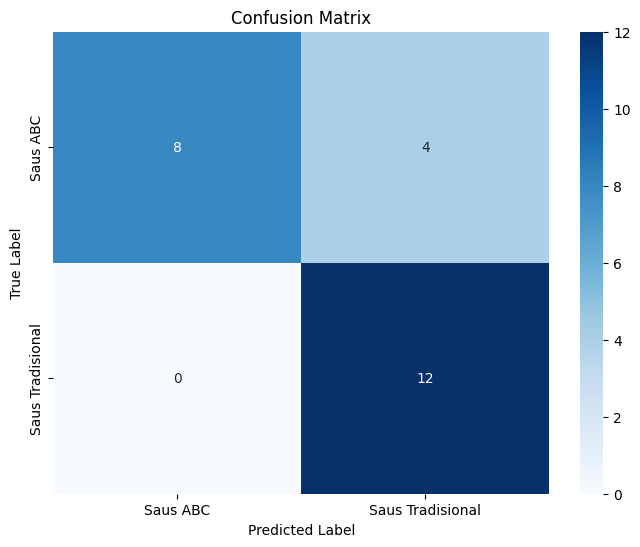

In [286]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

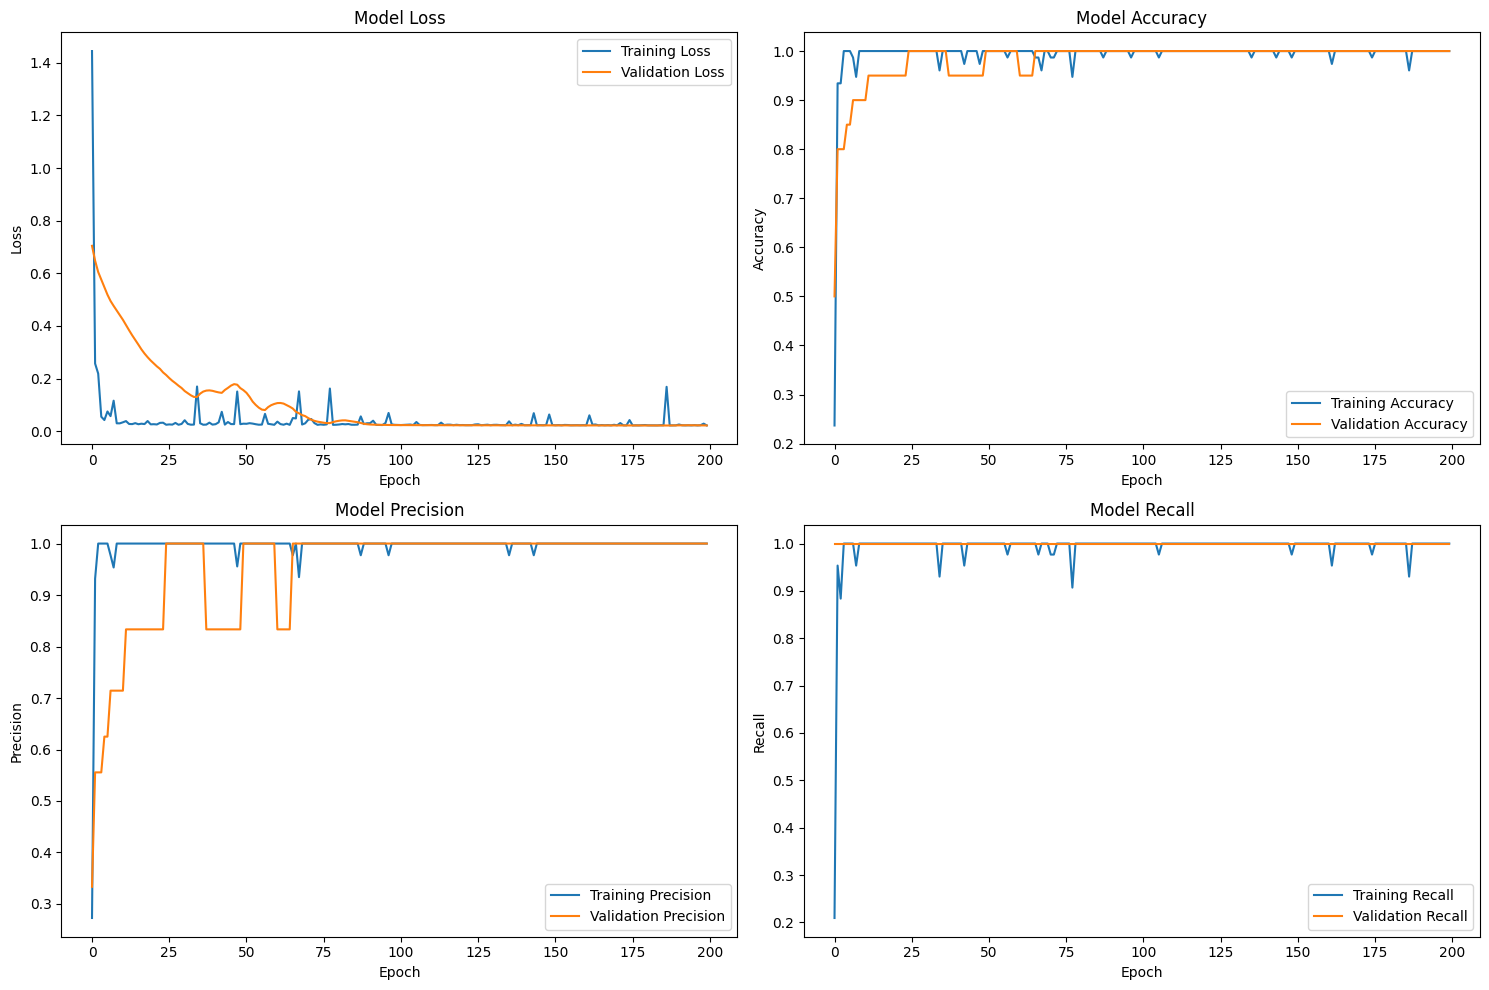

In [297]:
# Training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()